C:\Users\Anna\AppData\Local\Temp\ipykernel_3788\1285860396.py:38: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(111, polar=True)


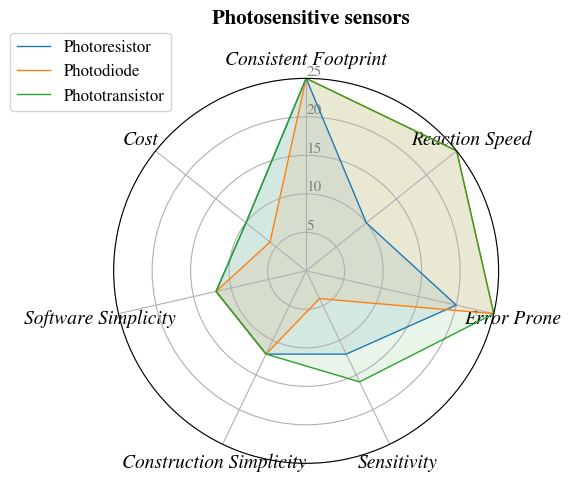

In [32]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

fig, ax = plt.subplots(figsize=(6,5))

plt.rcParams.update({'font.size': 12})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 12
fs = 12

# Set data
df = pd.DataFrame({
'group': ['Photoresistor','Photodiode','Phototransistor'],
'Consistent Footprint': [25,25,25],
'Reaction Speed': [10,25,25],
'Error Prone': [20,25,25],
'Sensitivity': [12,4,16],
'Construction Simplicity': [12,12,12],
'Software Simplicity': [12,12,12],
'Cost': [10,6,10]
})
 
# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories,  fontstyle='italic', size=14)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([5,10,15,20,25], ["5","10","15","20","25"], color="grey", size=11)
plt.ylim(0,25)
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Photoresistor")
ax.fill(angles, values, 'C0', alpha=0.1)
 
# Ind2
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Photodiode")
ax.fill(angles, values, 'C1', alpha=0.1)

# Ind3
values=df.loc[2].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Phototransistor")
ax.fill(angles, values, 'C2', alpha=0.1)
 
# Add legend
#plt.title("Photosensitive sensors", fontweight = 'bold')
plt.legend(loc='upper right', bbox_to_anchor=(0.17, 1.14), fontsize = fs)
fig.text(0.52, 1.0, 'Photosensitive sensors', va='center', ha='center', rotation='horizontal', fontsize=fs+3, weight='bold')

# Show the graph

name_file = "Solution_selection_photosensitive"
plt.savefig(f"../../LaTex/Master Thesis/figures/{name_file}.pdf")
plt.savefig(f"../../LaTex/Master Thesis/figures/{name_file}.png")
plt.savefig(f"../../LaTex/Master Thesis/figures/{name_file}.svg")

plt.show()


C:\Users\Anna\AppData\Local\Temp\ipykernel_3788\626866842.py:38: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(111, polar=True)


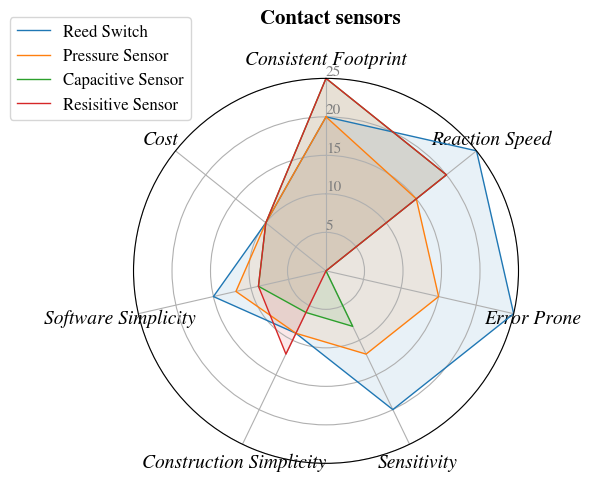

In [44]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

fig, ax = plt.subplots(figsize=(6,5))

plt.rcParams.update({'font.size': 12})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 12
fs = 12

# Set data
df = pd.DataFrame({
'group': ['Reed Switch','Pressure','Capacitive', 'Resistive'],
'Consistent Footprint': [20,15,25,25],
'Reaction Speed': [25,15,20,20],
'Error Prone': [25,15,0,0],
'Sensitivity': [20,12,8,0],
'Construction Simplicity': [9,9,6,12],
'Software Simplicity': [15,12,9,9],
'Cost': [10,10,10,10]
})
 
# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories,  fontstyle='italic', size=14)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([5,10,15,20,25], ["5","10","15","20","25"], color="grey", size=11)
plt.ylim(0,25)

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable

# Ind1
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Reed Switch")
ax.fill(angles, values, 'C0', alpha=0.1)
 
# Ind2
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Pressure Sensor")
ax.fill(angles, values, 'C1', alpha=0.1)

# Ind3
values=df.loc[2].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Capacitive Sensor")
ax.fill(angles, values, 'C2', alpha=0.1)

# Ind4
values=df.loc[3].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Resisitive Sensor")
ax.fill(angles, values, 'C3', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.17, 1.18), fontsize = fs)
fig.text(0.52, 1.0, 'Contact sensors', va='center', ha='center', rotation='horizontal', fontsize=fs+3, weight='bold')


name_file = "Solution_selection_contact"
plt.savefig(f"../../LaTex/Master Thesis/figures/{name_file}.pdf")
plt.savefig(f"../../LaTex/Master Thesis/figures/{name_file}.png")
plt.savefig(f"../../LaTex/Master Thesis/figures/{name_file}.svg")

plt.show()


C:\Users\Anna\AppData\Local\Temp\ipykernel_3788\2288964729.py:31: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(111, polar=True)


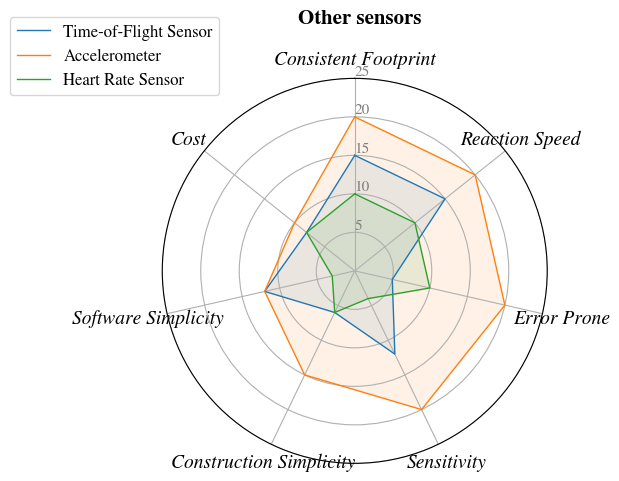

In [46]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

fig, ax = plt.subplots(figsize=(6,5))

# Set data
df = pd.DataFrame({
'group': ['Time-of-Flight Sensor','Accelerometer','Heart Rate Sensor'],
'Consistent Footprint': [15,20,10],
'Reaction Speed': [15,20,10],
'Error Prone': [5,20,10],
'Sensitivity': [12,20,4],
'Construction Simplicity': [6,15,6],
'Software Simplicity': [12,12,3],
'Cost': [8,10,8]
})
 
# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories,  fontstyle='italic', size=14)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([5,10,15,20,25], ["5","10","15","20","25"], color="grey", size=11)
plt.ylim(0,25)

 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable


values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Time-of-Flight Sensor")
ax.fill(angles, values, 'C0', alpha=0.1)

values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Accelerometer")
ax.fill(angles, values, 'C1', alpha=0.1)
 
values=df.loc[2].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Heart Rate Sensor")
ax.fill(angles, values, 'C2', alpha=0.1)


# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.17, 1.18), fontsize = fs)
fig.text(0.52, 1.0, 'Other sensors', va='center', ha='center', rotation='horizontal', fontsize=fs+3, weight='bold')


name_file = "Solution_selection_Other_sensors"
plt.savefig(f"../../LaTex/Master Thesis/figures/{name_file}.pdf")
plt.savefig(f"../../LaTex/Master Thesis/figures/{name_file}.png")
plt.savefig(f"../../LaTex/Master Thesis/figures/{name_file}.svg")

plt.show()